<a href="https://colab.research.google.com/github/maytanti/bitcoin-timeseries-forecast/blob/main/BTC_Exploratory_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
#import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet import Prophet



In [33]:
#read dats and save to dataframe
pd.set_option('display.max_columns', None)
df = pd.read_csv('coin_Bitcoin.csv')
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [4]:
#check dataframe info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2862 non-null   int64  
 1   Name       2862 non-null   object 
 2   Symbol     2862 non-null   object 
 3   Date       2862 non-null   object 
 4   High       2862 non-null   float64
 5   Low        2862 non-null   float64
 6   Open       2862 non-null   float64
 7   Close      2862 non-null   float64
 8   Volume     2862 non-null   float64
 9   Marketcap  2862 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 223.7+ KB


,SNo,High,Low,Open,Close,Volume,Marketcap
count,2862.00000,2862.000000,2862.000000,2862.000000,2862.000000,2.862000e+03,2.862000e+03
mean,1431.50000,4974.040239,4695.103027,4836.306834,4852.092547,8.978475e+09,8.591622e+10
std,826.33256,7188.836678,6667.197596,6933.573446,6975.105869,1.658135e+10,1.287414e+11
min,1.00000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,716.25000,426.047752,415.675751,421.204506,420.989243,2.786250e+07,5.988997e+09
50%,1431.50000,1197.334961,1164.174988,1180.100037,1182.809998,3.301950e+08,1.924238e+10
75%,2146.75000,8138.046589,7703.357500,7924.612338,7926.696939,1.296743e+10,1.387658e+11
max,2862.00000,58330.572142,55672.609513,57532.738864,57539.943668,3.509679e+11,1.072263e+12


In [34]:
#select only date and closing price
df.Date = pd.to_datetime(df.Date)
df.Date = df["Date"].dt.date
df.Date = pd.to_datetime(df.Date)
df_btc = df[["Date", "Close"]]

#setting date as index
df_btc1 = df_btc.set_index("Date")
df_btc1.sort_index(inplace=True)

df_btc1.head()

,Close
Date,
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999
2013-05-03,97.750000


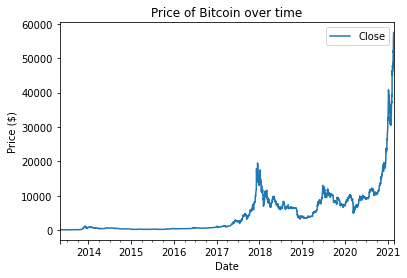

In [6]:
#Figure 1: Basic Plot (BTC Price over time)
fig1 = df_btc1.plot()
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Price of Bitcoin over time')
plt.show()


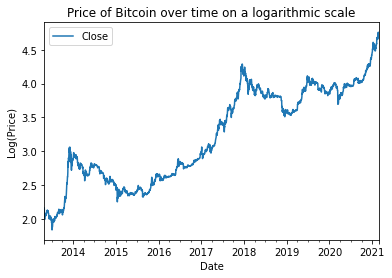

In [35]:
#Figure 2: Processed Basic Plot (BTC Price over time - Log Scale)

# convert price from dollar to logscale --> log(price)
df_btcLog = np.log10(df_btc1)

# plot datetime vs log(price)
fig2 = df_btcLog.plot()
plt.xlabel('Date')
plt.ylabel('Log(Price)')
plt.title('Price of Bitcoin over time on a logarithmic scale')
plt.show()


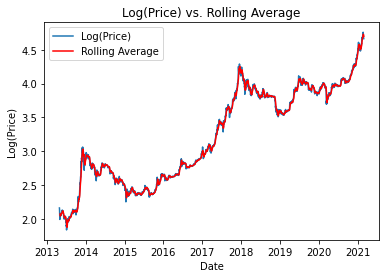

In [36]:
# Figure 3: Smoothen data with 7 days rolling average
fig3 = plt.figure()
rolling_average = df_btcLog.rolling(7).mean()
plt.plot(df_btcLog, label = "Log(Price)")
plt.plot(rolling_average, color = "red", label = "Rolling Average")
plt.xlabel('Date')
plt.ylabel('Log(Price)')
plt.title('Log(Price) vs. Rolling Average')
plt.legend()
plt.show()


               Close
Date                
2013-04-29  0.000000
2013-04-30  0.000000
2013-05-01  0.000000
2013-05-02  0.000000
2013-05-03  0.000000
2013-05-04  0.000000
2013-05-05 -0.007107
2013-05-06 -0.005190
2013-05-07  0.005382
2013-05-08  0.015198
2013-05-09  0.007508
2013-05-10  0.013369
2013-05-11  0.004561
2013-05-12  0.004133
2013-05-13  0.012183 



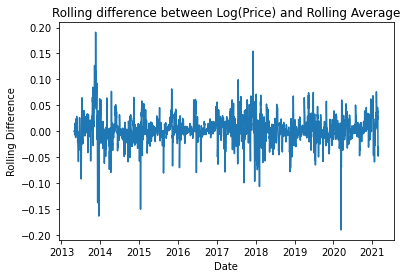

In [37]:
#The data needs to be stationarized in order to eliminate trend
#Subtract rolling average frmo original log transformed series. This eliminates the trend.
btc_rolling_difference = df_btcLog - rolling_average

#The first 6 values will be NaN due to the rolling average of 7 days. Replace NaN with 0 to avoid future errors.
btc_rolling_difference.Close[0:6] = 0
print(btc_rolling_difference.head(15), "\n")

# Figure4: Plot of the rolling difference (Log Dsta - Rolling Average)
fig4 = plt.figure()
plt.plot(btc_rolling_difference)
plt.xlabel('Date')
plt.ylabel('Rolling Difference')
plt.title('Rolling difference between Log(Price) and Rolling Average')
plt.show()


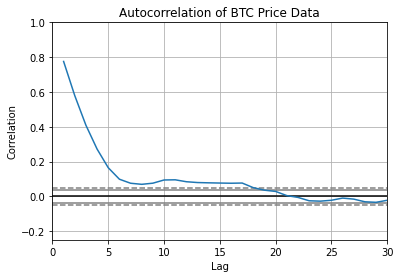

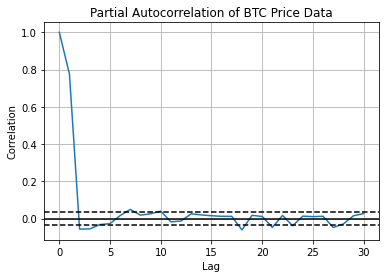

In [17]:
#Forecasting -- Method 1: ARIMA

#Figure 5: Plotting the autocorrelation of data (to find q)
fig5 = plt.figure()
autocorrelation_plot(btc_rolling_difference)
plt.axis([0,30,-0.25,1])
plt.title('Autocorrelation of BTC Price Data')
plt.ylabel('Correlation')
plt.show()

#lag appears to be at 18 days 
#this value goes inline with "q" because the value signifies the gap of time that we must consider when calculating the moving average, since it is not possible to encapture all the indirect factors influencing the two variables.

#Figure 6: Partial Autocorrelation (to find p)
fig6 = plt.figure()
pacf = statsmodels.tsa.stattools.pacf(btc_rolling_difference, nlags=30)
plt.plot(pacf)
plt.ylabel("Correlation")
plt.title('Partial Autocorrelation of BTC Price Data')
plt.xlabel("Lag")
plt.axhline(y=0,linestyle='-',color='black')
# Standard Error of Mean for 95% Confidence Interval = 1.96/sqrt(n)
plt.axhline(y=-1.96/np.sqrt(len(btc_rolling_difference)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(btc_rolling_difference)),linestyle='--',color='black')
plt.grid(True)
plt.show()

#lag appears to be at 2 days 
#this value goes inline with "p" because the value directly indicates the length of time that one variable has a direct influence on the other.


In [11]:
# Verifying the ARIMA Model

# For the ARIMA Model;
# p = 2 --> According to the partial autocorrelation method
# q = 18 --> According to the autocorrelation method
# d = 1 --> To make the data stationary, the data was differenced once eliminating trend.

model = ARIMA(df_btcLog, order=(2,1,18))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2861
Model:                ARIMA(2, 1, 18)   Log Likelihood                7381.799
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 05 Mar 2021   AIC                         -14719.599
Time:                        23:48:23   BIC                         -14588.503
Sample:                    04-30-2013   HQIC                        -14672.330
                         - 02-27-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0009      0.000      1.958      0.050   -1.03e-06       0.002
ar.L1.D.Close      0.3874        nan        nan        nan         nan         nan
ar.L2.D.Close      0.1071        nan

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt



<Figure size 432x288 with 0 Axes>

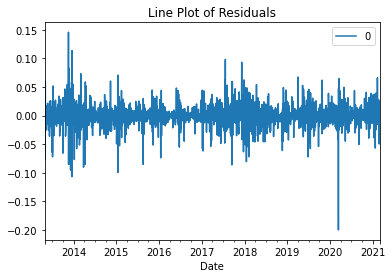

<Figure size 432x288 with 0 Axes>

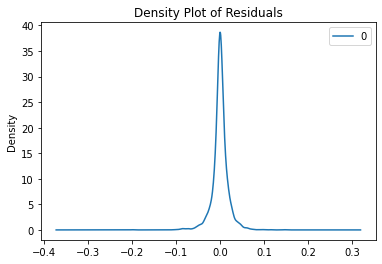


 Summary:
                 0
count  2861.000000
mean      0.000011
std       0.018337
min      -0.199658
25%      -0.006461
50%       0.000049
75%       0.007154
max       0.145708


In [12]:
# Figure 7: Line plot of residuals
fig7 = plt.figure()
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title("Line Plot of Residuals")
plt.show()

# Figure 8: Density plot of residuals
fig8 = plt.figure()
residuals.plot(kind='kde')
plt.ylabel("Density")
plt.title("Density Plot of Residuals")
plt.show()

# summary stats of residuals
print("\n Summary:")
print(residuals.describe())


In [ ]:
#Projecting with ARIMA -- One day future 'forecast' model

#Split data into train and test subsets
X = 10.0 ** (df_btcLog.values)
datesX = df_btcLog.index
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
plotDates = datesX[size:len(X)]

# Projecting with ARIMA 'Forecast' --- Walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,18))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluate forecasts
mae = mean_absolute_error(test, predictions)
print('MAE: %.3f' % mae)
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Figure 9: Plot of daily future forecasts against actual outcomes
fig9 = plt.figure(figsize=(13,10))
plt.plot(plotDates, test, label='Expected')
plt.plot(plotDates, predictions, label='Predicted')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Predicted and Expected BTC Price (ARIMA Forecast)')
plt.show()


KeyboardInterrupt: ignored

In [15]:
#Projecting with ARIMA -- Out-of-sample multiple day future 'prediction' model

#Define function for differencing the data to elimnate seasonality
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

#Split data into train and test subsets
X = 10.0 ** (df_btcLog.values)
datesX = df_btcLog.index
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
days_in_year = 365
plotDates = datesX[size:len(X)]

#Projecting with ARIMA 'prediction'
differenced = difference(train, days_in_year)

model = ARIMA(differenced, order=(2, 1, 18))
model_fit = model.fit()
start_index = len(differenced)
end_index = start_index + 572
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in train]
day = 1
predicted_results = list()

for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print("Predicted Day %d: %f" % (day, inverted))
    history.append(inverted)
    predicted_results.append(inverted)
    day += 1

#Evaluate forecast
mae = mean_absolute_error(test, predicted_results)
print('MAE: %.3f' % mae)
rmse = np.sqrt(mean_squared_error(test, predicted_results))
print('Test RMSE: %.3f' % rmse)


Predicted Day 1: 7236.973604
Predicted Day 2: 6857.218565
Predicted Day 3: 6789.371441
Predicted Day 4: 6468.838926
Predicted Day 5: 6646.867150
Predicted Day 6: 6313.166321
Predicted Day 7: 6447.520491
Predicted Day 8: 6452.650732
Predicted Day 9: 6295.020809
Predicted Day 10: 6195.183700
Predicted Day 11: 6127.945083
Predicted Day 12: 6108.953789
Predicted Day 13: 6529.533475
Predicted Day 14: 6414.593695
Predicted Day 15: 6523.350252
Predicted Day 16: 6395.358168
Predicted Day 17: 6615.287183
Predicted Day 18: 6460.946941
Predicted Day 19: 6597.593000
Predicted Day 20: 6764.658320
Predicted Day 21: 6795.887732
Predicted Day 22: 6731.147961
Predicted Day 23: 6902.332161
Predicted Day 24: 7109.532680
Predicted Day 25: 7057.257535
Predicted Day 26: 6986.077158
Predicted Day 27: 7043.824598
Predicted Day 28: 7198.352591
Predicted Day 29: 7277.009022
Predicted Day 30: 7263.769358
Predicted Day 31: 7364.956374
Predicted Day 32: 6795.832134
Predicted Day 33: 6531.962499
Predicted Day 34: 6

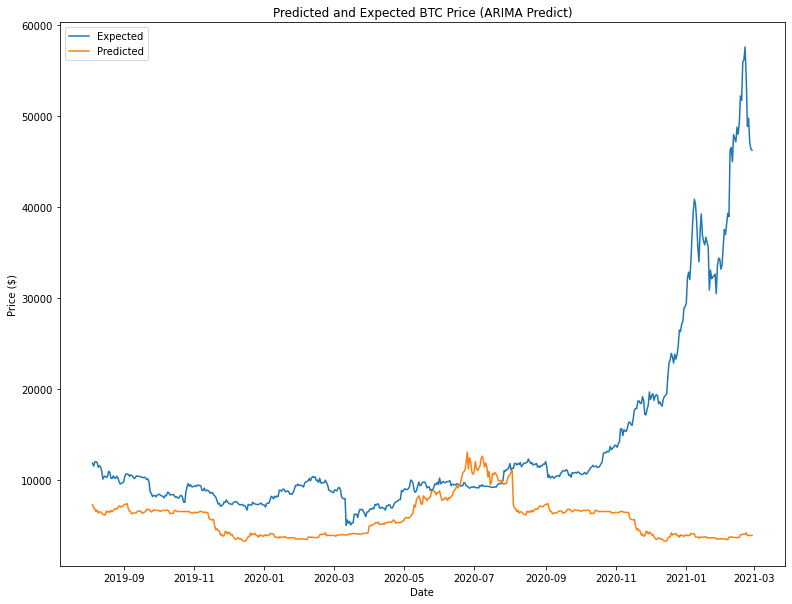

In [18]:
# Figure 10: Plot of multiple day out-of-sample future predictions against actual outcomes
fig10 = plt.figure(figsize=(13,10))
plt.plot(plotDates, test, label='Expected')
plt.plot(plotDates, predicted_results, label='Predicted')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Predicted and Expected BTC Price (ARIMA Predict)')
plt.show()


In [93]:
#Forecasting -- Method 2: Fb Prophet

#Copy and reformat the data for Prophet compatibility
df_btc_pht = df_btc.copy()
df_btc_pht.columns = ['ds', 'y']
W = df_btc_pht
size = int(len(W) * 0.80)
train, test = W[0:size], W[size:len(W)]

#Train prophet model
m = Prophet(seasonality_mode="multiplicative")
m.fit(train)

#Projecting with Prophet predict
future = m.make_future_dataframe(periods=len(test), freq='D')
forecast = m.predict(future)

#Evaluate forecast
y_true = test['y'].values
y_pred = forecast.yhat.values[-573:]
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7369.158
Test RMSE: 12587.405


<Figure size 936x720 with 0 Axes>

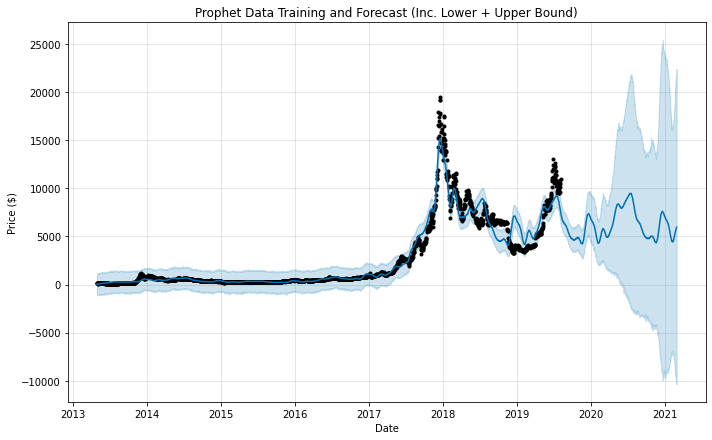

<Figure size 936x720 with 0 Axes>

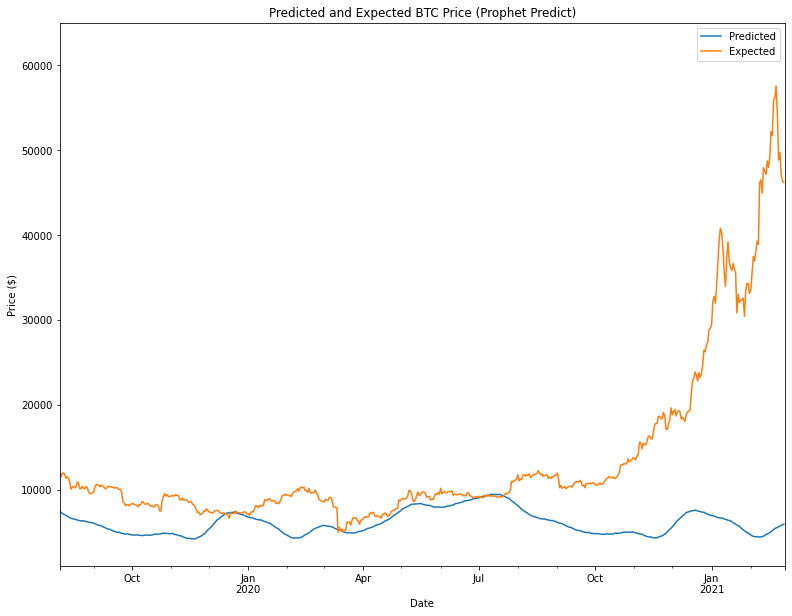

In [96]:
#Figure 11: Plot of Prophet data training
fig11 = plt.figure(figsize=(13,10))
m.plot(forecast)
plt.title('Prophet Data Training and Forecast (Inc. Lower + Upper Bound)')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.show()

#Figure 12: Plot of Prophet future predictions against actual outcomes (Prophet)
fig12 = plt.figure(figsize=(13,10))
ax = forecast.plot(x='ds', y='yhat', legend=True, label="Predicted", figsize=(13,10))
test.plot(x='ds', y='y', legend=True, label='Expected', ax=ax, xlim=('2019-08-05', '2021-02-28'), ylim=(1000,65000))
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Predicted and Expected BTC Price (Prophet Predict)')
plt.show()


In [28]:
#Forecasting -- Method 3: Stock-to-Flow
#Note; Stock to Flow = stock/flow

#Import Extra Modules for this Model
import datetime
import requests
import json

#Define function for extracting data from coinmetrics.io
def btcSupplyOnDate(date):
  url = (
      "https://community-api.coinmetrics.io/"
      + "v2/assets/btc/metricdata?metrics=SplyCur&start="
      + str(date)
      + "&end="
      + str(date)
      )
  cont = requests.get(url).json()
  supply = cont["metricData"]["series"][0]["values"][0]
  return float(supply)

#Create list for date entries and predicted price
dateList = list()
model_price_list = list()

#Calculate total number of days in test data (Ans: 2863)
datecheck = datetime.date(2021,3,1) - datetime(2013,4,29)  # == 2863

#Projecting with Stock to Flow Model
for t in range(2863):
  dateYesterday = datetime.date(2021,3,1) - datetime.timedelta(days=1 + t)
  datePeriodInit = dateYesterday - datetime.timedelta(days=463)
  supplyYesterday = btcSupplyOnDate(dateYesterday)
  supplyPeriodAgo = btcSupplyOnDate(datePeriodInit)
  stock_to_flow_ratio = supplyPeriodAgo / (
      (supplyYesterday - supplyPeriodAgo) / 463 * 365
      )
  # Formula for converting stock to flow
  stock_to_flow_usd = 0.18 * stock_to_flow_ratio ** 3.3
  print(dateYesterday, "Model Price:", stock_to_flow_usd)
  dateList.append(dateYesterday)
  model_price_list.append(stock_to_flow_usd)

2021-02-28 Model Price: 34011.85529663789
2021-02-27 Model Price: 33738.458929733795
2021-02-26 Model Price: 33599.916528988644
2021-02-25 Model Price: 33428.39190182092
2021-02-24 Model Price: 33265.867426597375
2021-02-23 Model Price: 33095.62617030673
2021-02-22 Model Price: 32906.14636189419
2021-02-21 Model Price: 32691.563866437944
2021-02-20 Model Price: 32502.02868519146
2021-02-19 Model Price: 32296.17030160255
2021-02-18 Model Price: 32074.237203464036
2021-02-17 Model Price: 31914.47976581318
2021-02-16 Model Price: 31757.011952167937
2021-02-15 Model Price: 31545.32322373411
2021-02-14 Model Price: 31335.27312186866
2021-02-13 Model Price: 31171.701067975926
2021-02-12 Model Price: 31054.810669767627
2021-02-11 Model Price: 30907.224316345222
2021-02-10 Model Price: 30753.258540263967
2021-02-09 Model Price: 30588.812600141046
2021-02-08 Model Price: 30451.61181220366
2021-02-07 Model Price: 30322.112009924254
2021-02-06 Model Price: 30195.667259479498
2021-02-05 Model Pric

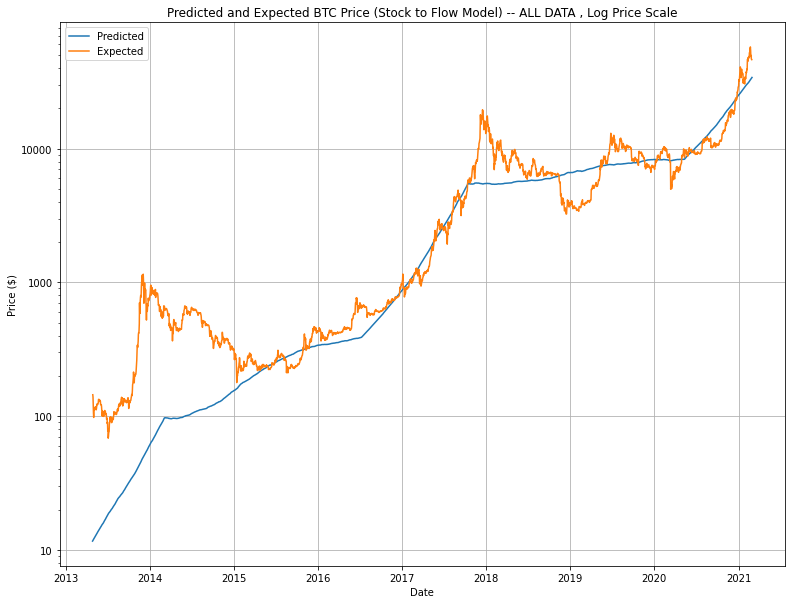

In [89]:
#Figure 13: Plot of Stock-to-Flow future predictions against actual outcomes (S2F) -- For All Data
#The stock to flow model is a socially acceptance model that was previously trained, so there is no need to train model

#Create new data frame with predicted price
dfs = pd.DataFrame(model_price_list, columns=['Price'])
dfs["Date"] = dateList
dfs = dfs.iloc[::-1]
dfs = dfs.set_index("Date")

# If an extra date wss added to the dataframe this uncomment line below to delete
# dfs.drop(datetime(2013,4,28))

fig13 = plt.figure(figsize=(13,10))
ax = fig13.add_subplot(1,1,1)
plt.plot(dfs, label='Predicted')
plt.plot(df_btc1, label='Expected')
plt.yscale('log')
for axis in [ax.yaxis]:
  axis.set_major_formatter(ScalarFormatter())

plt.grid()
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Predicted and Expected BTC Price (Stock to Flow Model) -- ALL DATA , Log Price Scale')
plt.show()

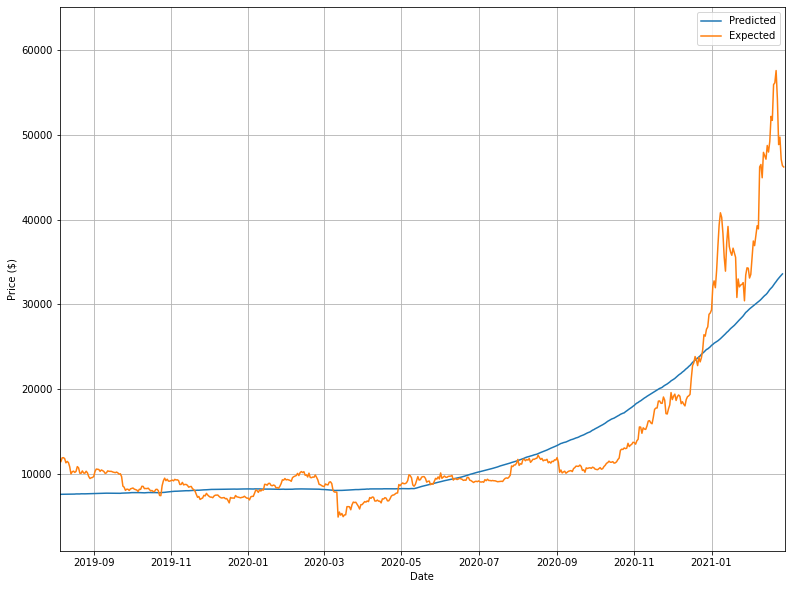

In [57]:
#Figure 14: Plot of Stock-to-Flow future predictions against actual outcomes (S2F) -- For Test Data
#For a fair comparison, the results of stock to flow model is scoped down to the same time period as the test data

#Create new data frames with predicted and expected price (test data period)
Z = df_btc1
size = int(len(Z) * 0.8)
test = Z[size:len(Z)]
y_pred = dfs[size:len(Z)]

fig14 = plt.figure(figsize=(13,10))
ax = plt.plot(y_pred, label='Predicted')
plt.plot(test, label='Expected')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.axis([datetime(2019,8,5), datetime(2021,2,28), 1000, 65000])
plt.show()

In [58]:
# #Evaluate forecast
mae = mean_absolute_error(test, y_pred)
print('MAE: %.3f' % mae)
rmse = np.sqrt(mean_squared_error(test, y_pred))
print('Test RMSE: %.3f' % rmse)

MAE: 2613.341
Test RMSE: 4472.824


In [72]:
# Preparing Data for comparing to HODL
# Note please run all code prior to this in the correct order, or data preparation may be incorrect.

A = df_btc1.values
datesX = df_btcLog.index
size = int(len(A) * 0.8)
test_data = A[size:len(A)]
predict_data = dfs.values[size:len(A)]
plotDates = datesX[size:len(A)]

arima_results = pd.DataFrame()
arima_results['Date'] = plotDates
arima_results['Predicted'] = predict_data
arima_results['Expected'] = test_data
print(arima_results)

          Date     Predicted      Expected
0   2019-08-05   7640.623674  11805.653725
1   2019-08-06   7649.093210  11478.169346
2   2019-08-07   7649.751716  11941.968341
3   2019-08-08   7654.532230  11966.407405
4   2019-08-09   7656.391490  11862.936760
..         ...           ...           ...
568 2021-02-23  32906.146362  48824.426869
569 2021-02-24  33095.626170  49705.333316
570 2021-02-25  33265.867427  47093.853019
571 2021-02-26  33428.391902  46339.760083
572 2021-02-27  33599.916529  46188.451275

[573 rows x 3 columns]


In [73]:
#Comparing trading with forecast model to HODL

# #Uncomment this part to test with ARIMA model instead of S2F model and comment out section right above
# #Prep test data
# # test_data_s = list()
# # for i in range(len(test)):
# #   T = test.item(i)
# #   test_data_s.append(T)

# #Prep predicted data
# predicted_data = list()
# for i in range(len(predicted_results)):
#   D1 = predicted_results[i]
#   D2 = D1.item(0)
#   predicted_data.append(D2)

#Create new dataframe with test and predicted data
# arima_results = pd.DataFrame()
# arima_results['Date'] = plotDates
# arima_results['Predicted'] = predicted_data
# arima_results['Expected'] = test_data_s

arima_results.Date = pd.to_datetime(arima_results.Date)
arima_data = arima_results.set_index("Date")

arima_data.head()


,Predicted,Expected
Date,,
2019-08-05,7640.623674,11805.653725
2019-08-06,7649.093210,11478.169346
2019-08-07,7649.751716,11941.968341
2019-08-08,7654.532230,11966.407405
2019-08-09,7656.391490,11862.936760


In [74]:
#Evaluate the success of each strategy based on monthly profit

#Empty lists for dates, profit from models, and unrealised profit from HODL
cashoutdate = list()
profit_list = list()
HODL_list = list()

#Calculate number of 30 days sets in test data (Ans: 19)
sets_of_30_days = int((len(df_btc1)*0.2)//30)  # == 19

#Price on the first day of test data
HODL_price = 11805.653725

#Calculate and track monthly profits
for m in range(sets_of_30_days):
  sample_data = arima_data.iloc[(m*30):(m*30+30), :]

  #select buying point -- lowest forecasted price in 30 day window
  lowest_predicted = np.min(sample_data.Predicted)
  lowest_index = sample_data.Predicted.idxmin()
  lowest_expected = sample_data.Expected[lowest_index]

  #select selling price -- highest forecasted price in 30 day window but must be after buying date
  selected_data = sample_data[sample_data.index>=lowest_index]

  highest_predicted = np.max(selected_data.Predicted)
  highest_index = selected_data.Predicted.idxmax()
  highest_expected = sample_data.Expected[highest_index]

  #calculate net profit and HODL profit
  end_value = (highest_expected/lowest_expected)*10000
  profit = round((end_value-10000),2)
  profit_list.append(profit)
  cashoutdate.append(highest_index)

  unrealised_HODL_vaue = (highest_expected/HODL_price)*10000
  unrealised_profit = round((unrealised_HODL_vaue-10000), 2)
  HODL_list.append(unrealised_profit)

  #print out information to verify (comment this part out if unnecessary)
  print(sample_data)

  print("P:", lowest_predicted)
  print("E:", lowest_expected)
  print(lowest_index)
  
  print("P:", highest_predicted)
  print("E:", highest_expected)
  print(highest_index)

  print("On the day:", highest_index)
  print("Profit:", profit)
  print("HODL Profit:", unrealised_profit, "\n")


              Predicted      Expected
Date                                 
2019-08-05  7640.623674  11805.653725
2019-08-06  7649.093210  11478.169346
2019-08-07  7649.751716  11941.968341
2019-08-08  7654.532230  11966.407405
2019-08-09  7656.391490  11862.936760
2019-08-10  7660.675453  11354.024218
2019-08-11  7658.427816  11523.579378
2019-08-12  7664.378735  11382.615956
2019-08-13  7668.406002  10895.830436
2019-08-14  7668.600578  10051.703931
2019-08-15  7666.368654  10311.545429
2019-08-16  7670.452795  10374.339347
2019-08-17  7675.910217  10231.743845
2019-08-18  7677.901309  10345.810380
2019-08-19  7695.458425  10916.053870
2019-08-20  7692.638995  10763.232630
2019-08-21  7687.295068  10138.049355
2019-08-22  7693.729303  10131.056102
2019-08-23  7711.212648  10407.965329
2019-08-24  7705.851901  10159.960539
2019-08-25  7704.144531  10138.517665
2019-08-26  7706.644413  10370.820161
2019-08-27  7711.938694  10185.499900
2019-08-28  7723.076388   9754.423273
2019-08-29  

In [76]:
#Check total accumulated profit after completing test data
summedProfit = np.sum(profit_list)
finalProfit = summedProfit
print("Accumulated Profit:", round(finalProfit, 2))

#Create dataframe for profit
net_profit = pd.DataFrame(profit_list, index=cashoutdate, columns=['Profit'])
net_profit.head()

Accumulated Profit: 18441.34


,Profit
2019-09-03,-1001.31
2019-10-03,-2203.50
2019-11-02,1185.34
2019-12-02,-2071.78
2020-01-01,-163.89


In [77]:
#Add accumulated profit and HODL unreaslised accumulated profit to dataframe
accumulated_profit = list()
for i in range(len(net_profit)):
  split_data = net_profit.iloc[0:(i+1), :]
  accumulated_profit.append(np.sum(split_data.Profit))

net_profit["Accumulated Profit"] = accumulated_profit
net_profit["Unrealised HODL Profit"] = HODL_list

In [78]:
#Add HODL monthly net profit to dataframe
HODL_np = np.diff(net_profit["Unrealised HODL Profit"])
a = -1235.76
HODL_np = np.insert(HODL_np, 0, -1235.76)

net_profit["HODL_np"] = HODL_np

print(net_profit)

             Profit  Accumulated Profit  Unrealised HODL Profit   HODL_np
2019-09-03 -1001.31            -1001.31                -1001.31  -1235.76
2019-10-03 -2203.50            -3204.81                -3003.36  -2002.05
2019-11-02  1185.34            -2019.47                -2101.48    901.88
2019-12-02 -2071.78            -4091.25                -3797.90  -1696.42
2020-01-01  -163.89            -4255.14                -3901.08   -103.18
2020-01-30  1061.05            -3194.09                -1945.39   1955.69
2020-03-01     0.00            -3194.09                -2747.16   -801.77
2020-03-31 -1861.59            -5055.68                -4546.13  -1798.97
2020-04-29  3321.23            -1734.45                -2545.07   2001.06
2020-05-30  -144.53            -1878.98                -1783.25    761.82
2020-06-29  -285.60            -2164.58                -2214.87   -431.62
2020-07-29  2147.60              -16.98                 -597.33   1617.54
2020-08-28   388.15              371.1

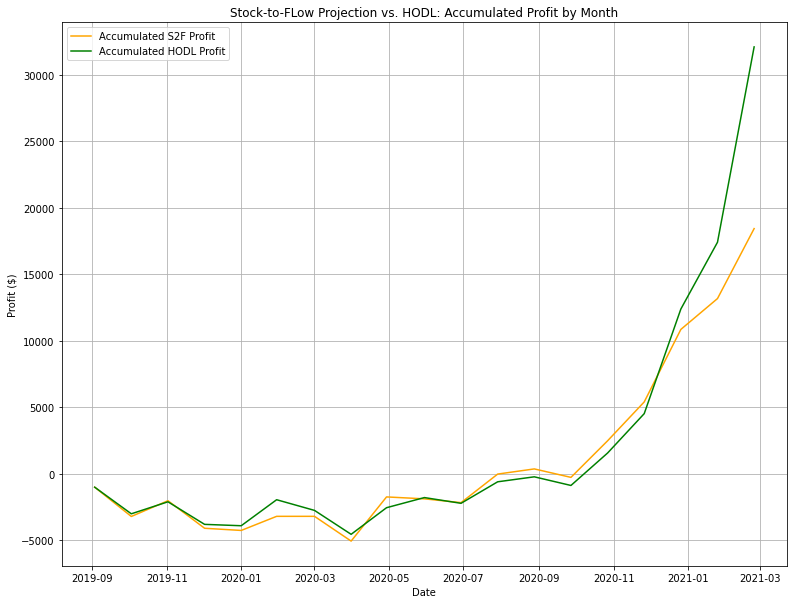

In [82]:
#Figure 15: Plot of Accumalated Trade and HODL Profit
fig15 = plt.figure(figsize=(13,10))
plt.plot(net_profit.index, net_profit["Accumulated Profit"], label='Accumulated S2F Profit', color='orange')
plt.plot(net_profit.index, net_profit["Unrealised HODL Profit"], label='Accumulated HODL Profit', color='green')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.legend(loc='best')
plt.title('Stock-to-FLow Projection vs. HODL: Accumulated Profit by Month')
plt.show()

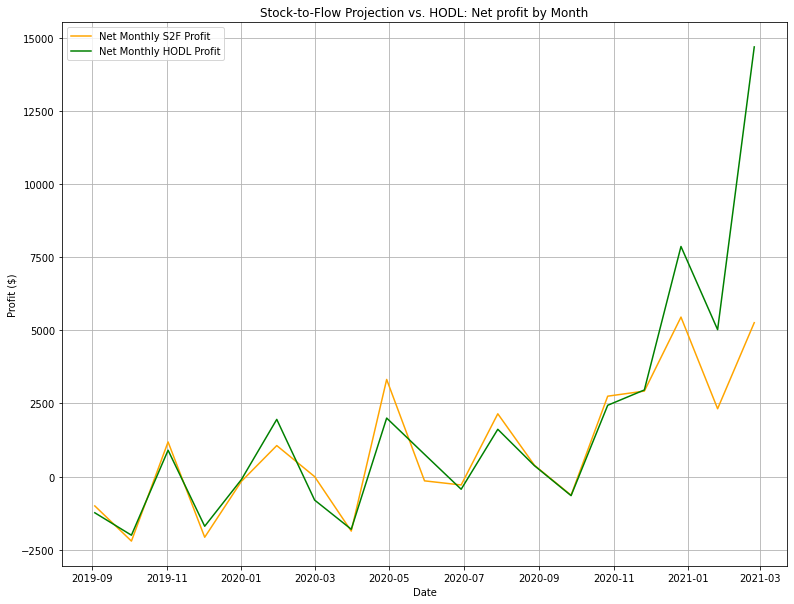

In [81]:
#Figure 16: Plot of Monthly Net Trade and HODL Profit
fig16 = plt.figure(figsize=(13,10))
plt.plot(net_profit.index, net_profit["Profit"], label='Net Monthly S2F Profit', color='orange')
plt.plot(net_profit.index, net_profit["HODL_np"], label='Net Monthly HODL Profit', color ='green')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.legend(loc='best')
plt.title('Stock-to-Flow Projection vs. HODL: Net profit by Month')
plt.show()